In [46]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 25 21:23:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |   2375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

By far, the most common timeseries-related task is **forecasting**: predicting what happens next in the series. Forecast electricity consumption a few hours in advance so you can anticipate demand, forecast revenue a few months in advance so you can plan your budget, forecast the weather a few days in advance so you can plan your schedule. Forecasting is what this chapter focuses on. But there’s actually a wide range of other things you can do with timeseries, such as:

- **Classification**: assign one or more categorical labels to a timeseries. For instance, given the timeseries of activity of a visitor on a website, classify whether the visitor is a bot or a human.
- **Event detection**: identify the occurrence of a specific, expected event within a continuous data stream. A particularly useful application is "hotword detection", where a model monitors a audio stream and detects utterances like "Ok Google" or "Hey Alexa".
- **Anomaly detection**: detect anything unusual happening within a continuous datastream. Unusual activity on your corporate network? Might be an attacker. Unusual readings on a manufacturing line? Time for a human to go take a look. Anomaly detection is typically done via unsupervised learning, because you often don’t know what kind of anomaly you’re looking for, and thus you can’t train on specific anomaly examples.

**Fourier analysis** (or the related Mel-frequency analysis) and other domain-specific **representations** can be useful as a form of feature engineering, a way to prepare data before training a model on it, to make the job of model easier. However, we won’t cover these techniques in these pages, and we will instead focus on the modeling part.

In this chapter, you’ll learn about **Recurrent Neural Networks (RNNs)** and how to apply them to timeseries forecasting.

## A temperature forecasting example

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2021-08-25 21:21:15--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.103.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.103.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  40.0MB/s    in 0.3s    

2021-08-25 21:21:16 (40.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Throughout this chapter, all of our code examples will target a single problem: **predicting the temperature 24 hours in the future**, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building. As you will see, it’s a fairly challenging problem!

We’ll use this temperature forecasting task to highlight what makes timeseries data **fundamentally different** from the kinds of datasets you’ve encountered so far, to show that densely-connected networks and convolutional networks **aren’t well-equipped to deal with it**, and to demonstrate a new kind of machine learning technique that really shines on this type of problem: recurrent neural networks (RNNs).

**Inspecting the data of the Jena weather dataset**

In [47]:
import pandas as pd

# make sure T is always the first column!
df = pd.read_csv(
    "jena_climate_2009_2016.csv", 
    parse_dates=["Date Time"], 
    date_parser=lambda x: pd.datetime.strptime(x, "%d.%m.%Y %H:%M:%S")
  ).set_index("Date Time")

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [22]:
df.shape

(420451, 14)

This outputs a count of $420,551$ lines of data (each line is a timestep: a record of a date and $14$ weather-related values), as well as the following header:

**Parsing the data**

Now, convert all $420,551$ lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the "Date Time" column.

In [48]:
temperature = df["T (degC)"]
raw_data = df.values.copy()

In [24]:
raw_data[:, 1], temperature

(array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82]), Date Time
 2009-01-01 00:10:00   -8.02
 2009-01-01 00:20:00   -8.41
 2009-01-01 00:30:00   -8.51
 2009-01-01 00:40:00   -8.31
 2009-01-01 00:50:00   -8.27
                        ... 
 2016-12-31 23:20:00   -4.05
 2016-12-31 23:30:00   -3.35
 2016-12-31 23:40:00   -3.16
 2016-12-31 23:50:00   -4.23
 2017-01-01 00:00:00   -4.82
 Name: T (degC), Length: 420451, dtype: float64)

**Plotting the temperature timeseries**

Here is the plot of temperature (in degrees Celsius) over time (see figure). On this plot, you can clearly see the yearly periodicity of temperature—the data spans 8 years.

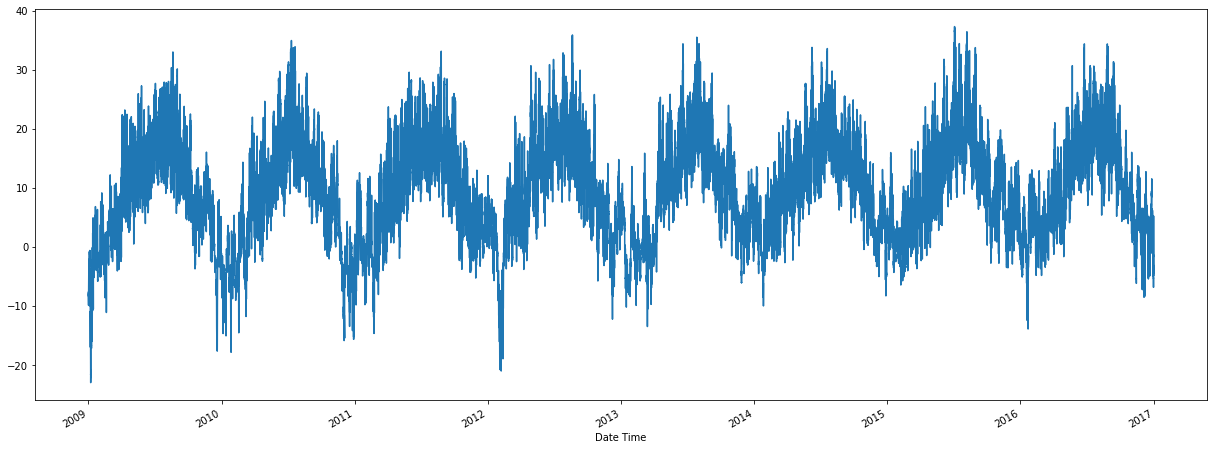

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(21,8))

df["T (degC)"].plot()

**Plotting the first 10 days of the temperature timeseries**

Here is a more narrow plot of the first 10 days of temperature data (see figure). Because the data is recorded every 10 minutes, you get 24 * 6 = 144 data points per day.

On this plot, you can see daily periodicity, especially evident for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

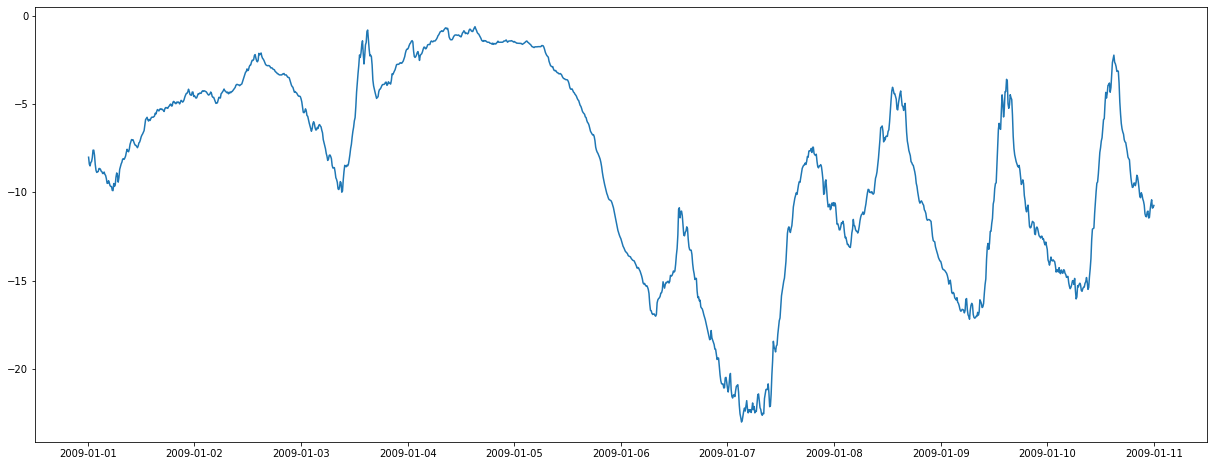

In [7]:
plt.figure(figsize=(21,8))
plt.plot(df["T (degC)"][:1440])

With our dataset, if you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the **reliable year-scale periodicity** of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out.

**Computing the number of samples we'll use for each data split.**

In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use **validation and test data that is more recent than the training data**, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect. Some problems happen to be considerably simpler if you reverse the time axis!

In [49]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

**Task**: The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

First, let’s preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a **different scale** (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3). We’ll normalize each timeseries independently so that they all take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

In [50]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Next, let’s create a ``Dataset`` object that yields **batches of data from the past five days along with a target temperature 24 hours in the future**. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample. Instead, we’ll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays, and nothing more.

We could easily write a Python generator to do this, but there’s a built-in dataset utility in Keras that does just that (``timeseries_dataset_from_array``), so we can save ourselves some work by using it. You can generally use it for any kind of timeseries forecasting task.

Let’s say you’re using `data = [0 1 2 3 4 5 6]` and `sequence_length=3`, then `timeseries_dataset_from_array` will generate the following samples: `[0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6]`.

For instance, with `data = [0 1 2 3 4 5 6 …]` and `sequence_length=3`, you could create a dataset to predict the next step in the series by passing `targets = [3 4 5 6 …]`. Let’s try it

In [32]:
# BONUS - Understand TIMESERIES_DATASET_FROM_ARRAY
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],  # 0 .. 6
    targets=int_sequence[3:],  # 3 .. 9
    sequence_length=3,
    batch_size=1,
)

for inputs, targets in dummy_dataset:
      print(inputs.numpy()[0], targets.numpy()[0])

[0 1 2] 3
[1 2 3] 4
[2 3 4] 5
[3 4 5] 6
[4 5 6] 7


**Instantiating Datasets for training, validation, and testing.**

We’ll use `timeseries_dataset_from_array` to instantiate three Datasets: one for training, one for validation, and one for testing.

We’ll use the following parameter values:

- `sampling_rate = 6` — Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
- `sequence_length = 120` — Observations will go back 5 days (120 hours).
- `delay = sampling_rate * (sequence_length + 24 - 1)` — The target for a sequence will be the temperature 24 hours after the end of the sequence.
- `start_index = 0` and `end_index = num_train_samples` for the training dataset, to only use the first 50% of the data.
- `start_index = num_train_samples` and `end_index = num_train_samples + num_val_samples` for the validation dataset, to only use the next 25% of the data.
- `start_index = num_train_samples + num_val_samples` for the test dataset, to use the remaining samples.

In [51]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# see: https://keras.io/api/preprocessing/timeseries/
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # Whether to shuffle output samples, or instead draw them in chronological order.
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our Datasets.**

Each Dataset yields a tuple `(samples, targets)`, where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are **randomly shuffled**, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

Before you start using black-box deep-learning models to solve the temperature-prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that you’ll have to beat in order to demonstrate the usefulness of more-advanced machine-learning models. Such common-sense baselines can be useful when you’re approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. **If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict "A"** when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat.

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. **Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now**. Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follow:

**Computing the common-sense baseline MAE**

In [9]:
import numpy as np

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius, and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, **you will be off by two and a half degrees on average**. It’s not too bad, but you probably won’t launch a weather forecasting service based on this heuristic. Now, the game is to use your knowledge of deep learning to do better.

### Let's try a basic machine learning model

**Training and evaluating a densely connected model**

In the same way that it’s useful to establish a common-sense baseline before trying machine-learning approaches, it’s useful to try **simple, cheap machine-learning models** (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a **regression problem**. We use **Mean Squared Error (MSE)** as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, a useful property for gradient descent. We will monitor MAE by adding it as a metric in compile().



In [35]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 39s 47ms/step - loss: 12.2376 - mae: 2.7138 - val_loss: 11.8743 - val_mae: 2.7529
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 8.9559 - mae: 2.3490 - val_loss: 11.7238 - val_mae: 2.7246
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.2070 - mae: 2.2507 - val_loss: 11.0383 - val_mae: 2.6173
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 7.7504 - mae: 2.1845 - val_loss: 10.4436 - val_mae: 2.5447
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 7.4385 - mae: 2.1408 - val_loss: 10.9527 - val_mae: 2.6134
Epoch 6/10
819/819 [==============================] - 39s 47ms/step - loss: 7.2112 - mae: 2.1085 - val_loss: 11.0585 - val_mae: 2.6316
Epoch 7/10
819/819 [==============================] - 39s 47ms/step - loss: 7.0148 - mae: 2.0793 - val_loss: 11.0750 - val_mae: 2.6205
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

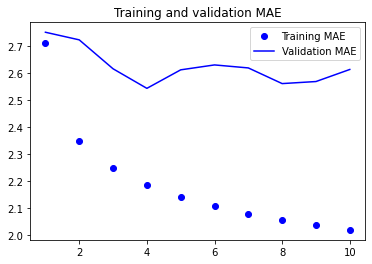

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Your common sense contains a lot of valuable information to which a machine-learning model doesn’t have access.

That’s a pretty significant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, it can sometimes fail to find a simple solution to a simple problem. That’s why leveraging good feature engineering and relevant architecture priors is essential: you need to be precisely telling your model what it should be looking for.

### Let's try a 1D convolutional model

You already know about the `Conv2D` and `SeparableConv2D` layers, which see their inputs through small windows that swipe across 2D grids. There are also 1D and even 3D versions of these layers: `Conv1D`, `SeparableConv1D`, and `Conv3D`.[19] The `Conv1D` layer relies on 1D windows that slide across input sequences, and the `Conv3D` layer relies on cubic windows that slide across input volumes.

You can thus build 1D convnets, strictly analoguous to 2D convnets. They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).

Let’s try one on our temperature forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via `MaxPooling1
D` layers), we’ll reduce the window size accordingly.


In [37]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)  # like an AveragePooling1D layer but with pool_size=steps, so produces a single value
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 41s 49ms/step - loss: 22.8770 - mae: 3.7231 - val_loss: 22.0425 - val_mae: 3.7190
Epoch 2/10
819/819 [==============================] - 40s 48ms/step - loss: 15.8395 - mae: 3.1586 - val_loss: 14.3727 - val_mae: 2.9916
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 14.5330 - mae: 3.0242 - val_loss: 16.0505 - val_mae: 3.2010
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 13.6019 - mae: 2.9211 - val_loss: 14.0016 - val_mae: 2.9557
Epoch 5/10
819/819 [==============================] - 41s 49ms/step - loss: 12.8347 - mae: 2.8369 - val_loss: 16.4323 - val_mae: 3.1930
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 12.1862 - mae: 2.7638 - val_loss: 14.7450 - val_mae: 3.0510
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 11.7119 - mae: 2.7080 - val_loss: 13.9547 - val_mae: 2.9391
Epoch 8/10
819/819 [============================

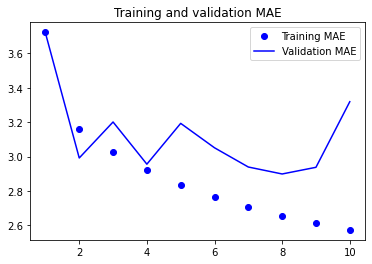

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/conv_model_metrics.png)



As it turns out, this model performs even worse than the densely-connected one, only achieving a validation MAE of about 2.9 degrees, far from the common-sense baseline. What went wrong here? Two things.

- First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
- Second, **order in our data matters—a lot**. The recent past is far more informative to predict the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.

### A first recurrent baseline

Neither the fully-connected approach nor the convolutional approach did well, but that doesn’t mean machine learning isn’t applicable to this problem. The densely-connected approach first flattened the timeseries, which removed the notion of time from the input data. The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. Let’s instead look at the data as what it is: **a sequence, where causality and order matter**.

There’s a family of neural network architectures that were designed specifically for this use case: **recurrent neural networks**. Among them, the **Long Short Term Memory (LSTM)** layer in particular has long been very popular. We’ll see in a minute how these models work—but let’s start but giving the LSTM layer a try.

**A simple LSTM-based model**

In [53]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 45.6204 - mae: 4.9380 - val_loss: 12.9080 - val_mae: 2.7179
Epoch 2/10
819/819 [==============================] - 43s 53ms/step - loss: 11.1857 - mae: 2.5926 - val_loss: 9.7588 - val_mae: 2.4216
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 9.7228 - mae: 2.4331 - val_loss: 10.0827 - val_mae: 2.4385
Epoch 4/10
819/819 [==============================] - 43s 53ms/step - loss: 9.3188 - mae: 2.3786 - val_loss: 10.4338 - val_mae: 2.4964
Epoch 5/10
819/819 [==============================] - 43s 53ms/step - loss: 9.0297 - mae: 2.3394 - val_loss: 10.1962 - val_mae: 2.4800
Epoch 6/10
819/819 [==============================] - 43s 53ms/step - loss: 8.8235 - mae: 2.3096 - val_loss: 10.2225 - val_mae: 2.4893
Epoch 7/10
819/819 [==============================] - 43s 53ms/step - loss: 8.6413 - mae: 2.2818 - val_loss: 10.4956 - val_mae: 2.5157
Epoch 8/10
819/819 [==============================] - 

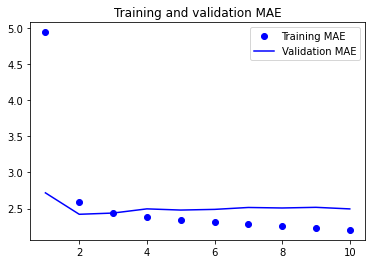

In [54]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Figure shows the results. Much better! We achieve a validation MAE as low as 2.36 degrees, and a test MAE of 2.55 degrees. The LSTM-based model can finally beat the common-sense baseline (albeit just by a bit, for now), demonstrating the value of machine learning on this task.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/lstm_model_metrics.png)

## Understanding recurrent neural networks

A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept in between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. For instance, this is what you did in the densely-connected network example: we flattened our five days of data into a single large vector and processed it in one go. Such networks are called **feedforward networks**.

A **recurrent neural network (RNN)** adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and **maintaining a state** containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop (see figure 10.6).

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/simplernn.png)

![grafik.png](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_1503.png)

The state of the RNN is reset between processing two different, independent sequences (such as two samples in a batch), so you still consider one sequence to be a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.




**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/unrolled_lstm_1.png)

### A recurrent layer in Keras

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_1504.png)
Figure 15-4. Seq-to-seq (top left), seq-to-vector (top right), vector-to-seq (bottom left), and Encoder–Decoder (bottom right) networks

**A RNN layer that can process sequences of any length**

The process you just naively implemented in NumPy corresponds to an actual Keras layer—the `SimpleRNN` layer.

There is one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not a single sequence as in the NumPy example. This means it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, input_features)`. When specifying the shape argument of your initial `Input()`, note that you can set the timesteps entry to `None`, which enables your network to process sequences of arbitrary length. Like this:


In [41]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

This is especially useful if your model is meant to process sequence of variable length. However, if all of your sequences have the same length, I recommend specifying a complete input shape, since it enables model.summary() to display output length information, which is always nice, and it can unlock some performance optimizations (see "Note on RNN runtime performance" below).

**A RNN layer that returns only its last output step**

All recurrent layers in Keras (`SimpleRNN`, `LSTM`, and `GRU`) can be run in two different modes: they can return either **full sequences of successive outputs** for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`) or only the **last output for each input sequence** (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor argument. Let’s look at an example that uses `SimpleRNN` and returns only the output at the last timestep:

In [42]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**A RNN layer that returns its full output sequence**

In [43]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_1507.png)

It’s sometimes useful to **stack several recurrent layers** one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return full sequence of outputs:

In [44]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

Now, in practice, you’ll rarely work with the `SimpleRNN` layer. It’s generally too simplistic to be of real use. In particular, `SimpleRNN` has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, in practice, such long-term dependencies prove impossible to learn. This is due to the **vanishing gradient problem**, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes **untrainable**. The theoretical reasons for this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s.[20]

Thankfully, `SimpleRNN` isn’t the only recurrent layer available in Keras. There are two others: `LSTM` and `GRU`, which were designed to address these issues.

Let’s consider the `LSTM` layer. The underlying **Long Short-Term Memory (LSTM)** algorithm was developed by Hochreiter and Schmidhuber in 1997;[21] it was the culmination of their research on the vanishing gradient problem.

This layer is a variant of the `SimpleRNN` layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what `LSTM` does: it saves information for later, thus preventing older signals from gradually vanishing during processing. This should remind you of residual connections, which you learned about in chapter 9: it’s pretty much the same idea.

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ft1.daumcdn.net%2Fthumb%2FR1280x0%2F%3Ffname%3Dhttp%3A%2F%2Ft1.daumcdn.net%2Fbrunch%2Fservice%2Fuser%2FIgT%2Fimage%2Fpm1pte_LEYjiZkbeoS-SUXF4-yg.png&f=1&nofb=1)

![](https://upload-images.jianshu.io/upload_images/5782625-04f01e6d045decab.png)


![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fpenseeartificielle.fr%2Fwp-content%2Fuploads%2F2019%2F10%2Flstm-vs-gru-1068x679.png&f=1&nofb=1)

### Using recurrent dropout to fight overfitting

Next, we’ll review a number of more advanced features of RNNs, which can help you get the most out of your deep-learning sequence models. By the end of the section, you’ll know most of what there is to know about using recurrent networks with Keras.



We’ll cover the following:

- **Recurrent dropout** — A variant of dropout, used to fight overfitting in recurrent layers.
- **Stacking recurrent layers** — This increases the representational power of the model (at the cost of higher computational loads).
- **Bidirectional recurrent layers** — These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

**Training and evaluating a dropout-regularized LSTM**

Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units. Let’s add recurrent dropout to the LSTM layer of our first LSTM example and see how doing so impacts overfitting.

Thanks to dropout, we won’t need rely as much on network size for regularization, so we’ll use a LSTM layer with twice as many units, which should hopefully be more expressive (without dropout, this network would have started overfitting right away—try it). Because networks being regularized with dropout **always take much longer to fully converge**, we’ll train the model for five times as many epochs.

In [52]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25, unroll=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 139s 124ms/step - loss: 30.9475 - mae: 4.0819 - val_loss: 9.5158 - val_mae: 2.3946
Epoch 2/50
819/819 [==============================] - 98s 120ms/step - loss: 15.0396 - mae: 3.0156 - val_loss: 9.0513 - val_mae: 2.3429
Epoch 3/50
819/819 [==============================] - 98s 119ms/step - loss: 14.3018 - mae: 2.9328 - val_loss: 9.2646 - val_mae: 2.3538
Epoch 4/50
819/819 [==============================] - 97s 119ms/step - loss: 13.8044 - mae: 2.8837 - val_loss: 9.0818 - val_mae: 2.3326
Epoch 5/50
819/819 [==============================] - 99s 120ms/step - loss: 13.3227 - mae: 2.8318 - val_loss: 8.9170 - val_mae: 2.3161
Epoch 6/50
819/819 [==============================] - 99s 120ms/step - loss: 13.0237 - mae: 2.8032 - val_loss: 9.1629 - val_mae: 2.3445
Epoch 7/50
819/819 [==============================] - 98s 119ms/step - loss: 12.8739 - mae: 2.7814 - val_loss: 8.9975 - val_mae: 2.3235
Epoch 8/50
819/819 [===========================

KeyboardInterrupt: ignored

Figure 10.11 shows the results. Success! We’re no longer overfitting during the first 20 epochs. We achieve a validation MAE as low as 2.27 degrees (7% improvement over the no-learning baseline) and a test MAE of 2.45 degrees (6.5% improvement over the baseline). Not too bad.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/lstm_dropout_model_metrics.png)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)  #  unrolling can help TensorFlow optimize the underlying computation graph

### Stacking recurrent layers

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, not too long ago the Google Translate algorithm was powered by a stack of seven large LSTM layers—that’s huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. As you’ve already learned, this is done by specifying `return_sequences=True`.

**Training and evaluating a dropout-regularized, stacked GRU model**

In [55]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True, unroll=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5, unroll=True)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 278s 219ms/step - loss: 24.8920 - mae: 3.6830 - val_loss: 9.2470 - val_mae: 2.3440
Epoch 2/50
819/819 [==============================] - 165s 201ms/step - loss: 14.0736 - mae: 2.9060 - val_loss: 9.0127 - val_mae: 2.3300
Epoch 3/50
819/819 [==============================] - 164s 199ms/step - loss: 13.3419 - mae: 2.8304 - val_loss: 9.0814 - val_mae: 2.3421
Epoch 4/50
819/819 [==============================] - 166s 203ms/step - loss: 12.8813 - mae: 2.7776 - val_loss: 8.7367 - val_mae: 2.2943
Epoch 5/50
819/819 [==============================] - 165s 201ms/step - loss: 12.4973 - mae: 2.7392 - val_loss: 9.1048 - val_mae: 2.3415
Epoch 6/50
819/819 [==============================] - 165s 201ms/step - loss: 12.1500 - mae: 2.7010 - val_loss: 9.4548 - val_mae: 2.4073
Epoch 7/50
819/819 [==============================] - ETA: 0s - loss: 11.8236 - mae: 2.6665

KeyboardInterrupt: ignored

Figure 10.12 shows the results. We achieve a test MAE of 2.39 degrees (a 8.8% improvement over the baseline). You can see that the added layer does improve the results a bit, though not dramatically. You may be seeing diminishing returns from increasing network capacity at this point.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/stacked_gru_dropout_model_metrics.png)

### Using bidirectional RNNs

The last technique introduced in this section is called bidirectional RNNs. A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It’s frequently used in natural-language processing—you could call it the Swiss Army knife of deep learning for natural-language processing.

A bidirectional RNN exploits the order sensitivity of RNNs: it consists of using two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

Remarkably, the fact that the RNN layers in this section have processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. At least, it’s a decision we made no attempt to question so far. Could the RNNs have performed well enough if they processed input sequences in antichronological order, for instance (newer timesteps first)? 

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/backwards_lstm_model_metrics.png)

The reversed-order LSTM strongly underperforms even the common-sense baseline, indicating that in this case, chronological processing is important to the success of the approach. This makes perfect sense: the underlying LSTM layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem (that’s what makes the common-sense baseline fairly strong). Thus the chronological version of the layer is bound to outperform the reversed-order version.

Importantly, an RNN trained on reversed sequences will learn different representations than one trained on the original sequences, much as you would have different mental models if time flowed backward in the real world—if you lived a life where you died on your first day and were born on your last day. In machine learning, representations that are different yet useful are always worth exploiting, and the more they differ, the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can help boost performance on a task. This is the intuition behind ensembling, a concept we’ll explore in chapter 13.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/bidirectional_rnn.png)

**Training and evaluating a bidirectional LSTM**

To instantiate a bidirectional RNN in Keras, you use the `Bidirectional` layer, which takes as its first argument a recurrent layer instance. `Bidirectional` creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order. You can try it on our temperature forecasting task:

In [56]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 26.3098 - mae: 3.6728 - val_loss: 10.8784 - val_mae: 2.5667
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 9.5380 - mae: 2.4138 - val_loss: 10.1127 - val_mae: 2.4521
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 8.7167 - mae: 2.3021 - val_loss: 9.7749 - val_mae: 2.4153
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 8.1328 - mae: 2.2265 - val_loss: 10.0084 - val_mae: 2.4510
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 7.6977 - mae: 2.1654 - val_loss: 10.0869 - val_mae: 2.4549
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 7.3442 - mae: 2.1146 - val_loss: 10.4117 - val_mae: 2.5031
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 7.1103 - mae: 2.0799 - val_loss: 10.6687 - val_mae: 2.5305
Epoch 8/10
 47/819 [>.............................] - E

KeyboardInterrupt: ignored

You’ll find that it doesn’t perform as well as the plain LSTM layer. It’s easy to understand why: all the **predictive capacity must come from the chronological half of the network**, because the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past in this case). At the same time, the presence of the antichronological half doubles the network’s capacity and causes it to start overfitting much earlier.

However, **bidirectional RNNs are a great fit for text data—or any other kind of data where order matters**, yet where which order you use doesn’t matter. In fact, for a while in 2016, bidirectional LSTMs were considered the state-of-the-art on many natural language processing tasks (before the rise of the Transformer architecture, which you will learn about in the next chapter).


### *_Going even further_*



There are many other things you could try, in order to improve performance on the temperature-forecasting problem:

- Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout. The current choices are largely arbitrary and thus probably suboptimal.
- Adjust the learning rate used by the RMSprop optimizer, or try a different optimizer.
- Try using a stack of Dense layers as the regressor on top of the recurrent layer, instead of a single Dense layer.
- Improve the input to the model: try using longer or shorter sequences, a different sampling rate, or start doing feature engineering.

In my experience, improving on the no-learning baseline by about 10% is likely the best you can do with this dataset. This isn’t so great, but these results make sense: while near-future weather is highly predictable if you have access to data from a wide grid of different locations, it’s not very predictable if you only have measurements from a single location. The evolution of the weather where you are depends on current weather patterns in surrounding locations.

## Chapter summary

- As you first learned in chapter 5, when approaching a new problem, it’s good to first establish common-sense baselines for your metric of choice. If you don’t have a baseline to beat, you can’t tell whether you’re making real progress.
- Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
- When you have data where ordering matters, and in particular for timeseries data, recurrent networks are a great fit, and easily outperform models that first flatten the temporal data. The two essential `RNN` layers available in Keras are the `LSTM` layer and the `GRU` layer.
- To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all you have to do is use the `recurrent_dropout` arguments of recurrent layers.
- **Stacked `RNNs`** provide more representational power than a single `RNN` layer. They’re also much more expensive and thus not always worth it. Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.